In [98]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from linear_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
import wandb
import jPCA

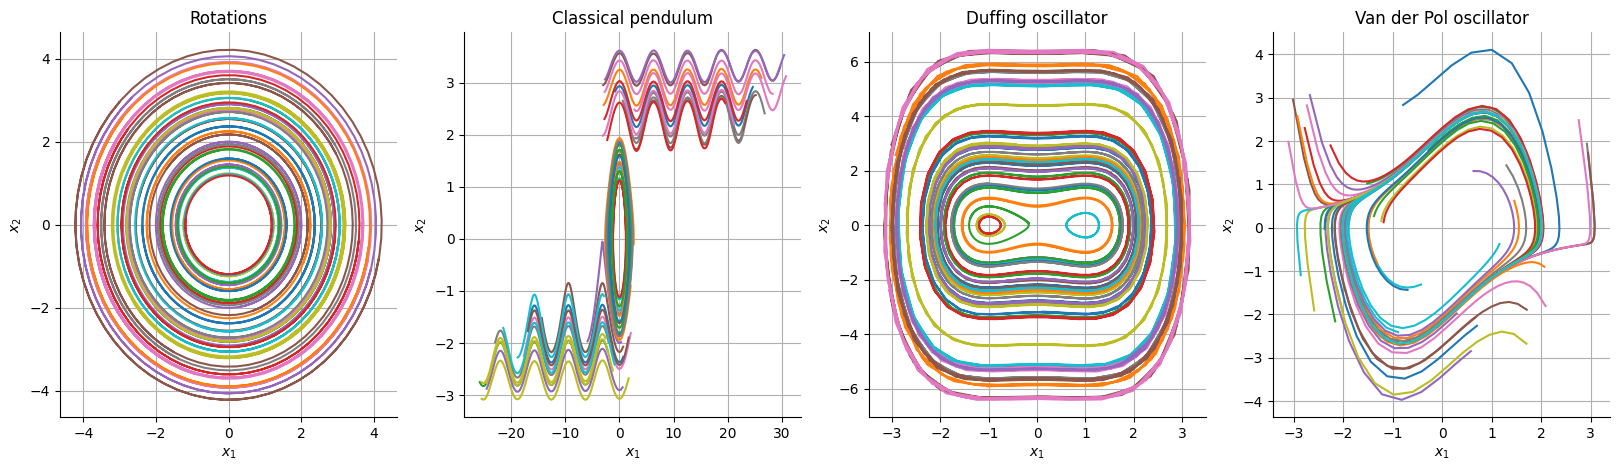

In [70]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]

time_steps=100
t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], time_steps)     # time points where the solution is computed


num_trajectories = 40

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))


for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[0].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[0].set_title('Rotations')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(pendulum_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[1].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[1].set_title('Classical pendulum')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(duffing_oscillator, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[2].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[2].set_title('Duffing oscillator')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[3].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[3].set_title('Van der Pol oscillator')

for ax in axs:
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.grid()
    ax.spines[['right', 'top']].set_visible(False)




# plt.figure(figsize=(3,3))
# for i,initial_conditions in enumerate(initial_conditions_list):
#     plt.plot(X[i,0,:],X[i,10,:] )

(40, 10, 100)


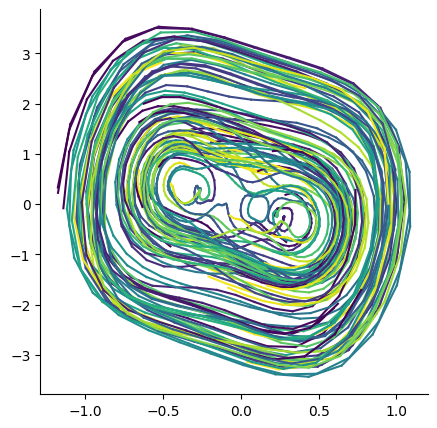

In [121]:
seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)

#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(duffing_oscillator, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)

# num_trajectories = 40
# time_steps = 50
# time = jnp.linspace(0, 2 *jnp.pi, time_steps)[:, jnp.newaxis]
# radii = jnp.linspace(0.1, 2, num_trajectories)
# radii = random.permutation(key, radii)
# phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)

# sine_waves = jnp.sin(time + phases) * radii
# cosine_waves = jnp.cos(time + phases) * radii
# X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200


# mean = 0
# std_dev = 1
# trajectories_1 = np.random.normal(loc=mean, scale=std_dev, size=(num_trajectories, time_steps))
# trajectories_2 = np.random.normal(loc=mean, scale=std_dev, size=(num_trajectories, time_steps))
# combined_trajectories = np.stack((trajectories_1, trajectories_2), axis=1)
# X = jnp.concatenate((X, jnp.array(combined_trajectories)), axis=1)
# print(X.shape)

# r = radii * jnp.cos(time + phases)
# theta = radii * jnp.sin(time + phases)
# x = r * np.cos(theta)
# y = r * np.sin(theta)
# X = jnp.stack([x.T, y.T], axis=1)


proj_dims = 10
proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
print(X.shape)

# noise = random.normal(subkey, (X.shape)) 
# X += 0.01 * (noise)  
# X = jnp.array(X)

X, _ = pre_processing(X, pca=False, soft_normalize=False)

split = 10
X_train = X[split:]
X_test = X[:split]
K, N, T = X_train.shape
plot_2D(X_train)

In [122]:
wandb.init(project="SCA-project-toydata", name="run_1", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X_train, d=2, learning_rate=0.01, iterations=500) 
wandb.finish

Iteration 0, S: 55.279869079589844, S_ratio: 0.3157590627670288
Iteration 10, S: 108.15402221679688, S_ratio: 0.3923642337322235
Iteration 20, S: 184.0290985107422, S_ratio: 0.2675960063934326
Iteration 30, S: 567.6959838867188, S_ratio: 0.2455487996339798
Iteration 40, S: 350.47259521484375, S_ratio: 0.4177200198173523
Iteration 50, S: 1183.920166015625, S_ratio: 0.3874357342720032
Iteration 60, S: 1738.688720703125, S_ratio: 0.26005202531814575
Iteration 70, S: 1895.810791015625, S_ratio: 0.24180833995342255
Iteration 80, S: 1496.2135009765625, S_ratio: 0.2525712251663208
Iteration 90, S: 1380.0631103515625, S_ratio: 0.310161828994751
Iteration 100, S: 2111.543212890625, S_ratio: 0.23959901928901672
Iteration 110, S: 2161.63720703125, S_ratio: 0.4080184996128082
Iteration 120, S: 2141.0224609375, S_ratio: 0.28544628620147705
Iteration 130, S: 2510.106689453125, S_ratio: 0.21570605039596558
Iteration 140, S: 3627.69140625, S_ratio: 0.2653668522834778
Iteration 150, S: 1495.78662109375

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

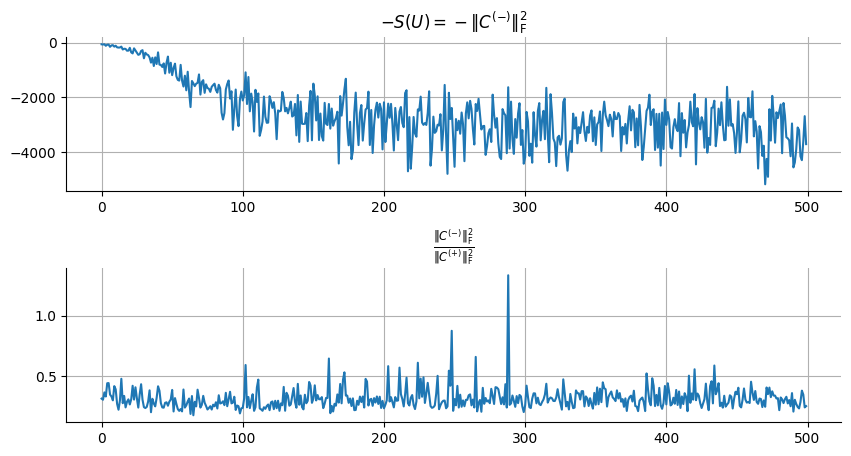

In [123]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)


sca  var 1.00
 s: 0.3321591913700104


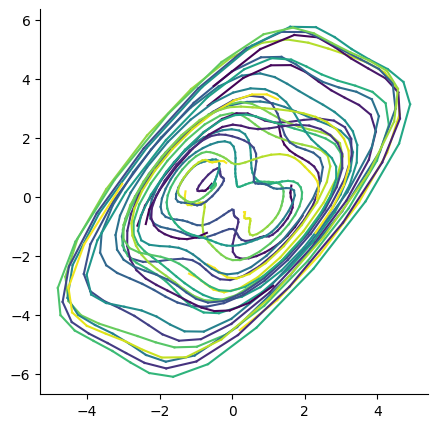

In [124]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X_test)
plot_2D(Y)
print(f"sca  var {var_explained(X_test, U_qr):.2f}")

print(f" s: { np.mean(compute_S(jnp.array(Y))) }")

pca var 1.00
 s: 0.33204808831214905


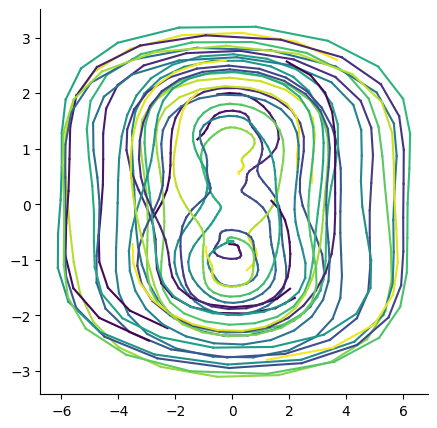

In [125]:
""" PCA """
X_train_pca = np.concatenate(X_train.swapaxes(1,2))
X_test_pca = np.concatenate(X_test.swapaxes(1,2))
full_data_var = np.sum(np.var(X_test_pca, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_train_pca).transform(X_test_pca)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
print(f"pca var {var_explained(X_test, PCs.T):.2f}")

print(f" s: { np.mean(compute_S(jnp.array(Y_pca))) }")


# kernel_pca = KernelPCA(
#     n_components=2, kernel="rbf", gamma=1e-2
# )
# X_kernel_pca = kernel_pca.fit(X_train_pca).transform(X_test_pca)
# X_kernel_pca = X_kernel_pca.reshape(-1, len(t_eval), num_pcs).swapaxes(1,2)
# plt.figure()
# plot_2D(X_kernel_pca)

variance captured ratio 0.999999999999999
s = 0.5677042007446289


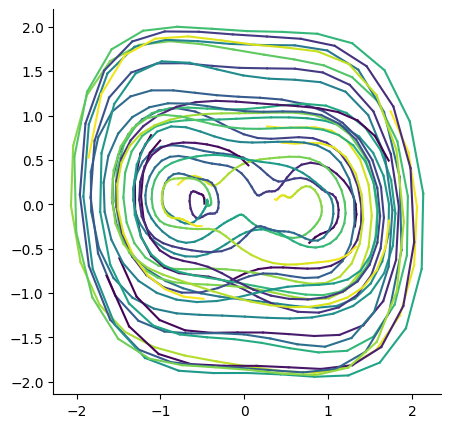

In [126]:
""" jPCA """
X_jpca, _ = pre_processing(X, soft_normalize='max', num_pcs=6)
X_jpca_ls = [X_jpca[i].T for i in range(X_jpca.shape[0])]
X_jpca_train = X_jpca_ls[split:] 
X_jpca_test = X_jpca_ls[:split] 
times = np.arange(-50, 555, 5).tolist()                                              #(140,); but -250:445 

jpca = jPCA.JPCA(num_jpcs=2)
(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt) = jpca.fit(X_jpca_train, times=times, tstart=times[0], tend=times[-1], soft_normalize=0, subtract_cc_mean=False, pca=False) 

jpcs = jpca.jpcs
print(f"variance captured ratio {var_explained(X_jpca[:split], jpcs)}")                 #:.2f

Y_jpca = jnp.array((X_jpca_test @ jpcs).swapaxes(1,2))
print(f's = {np.mean(compute_S(Y_jpca))}')

plot_2D(Y_jpca)

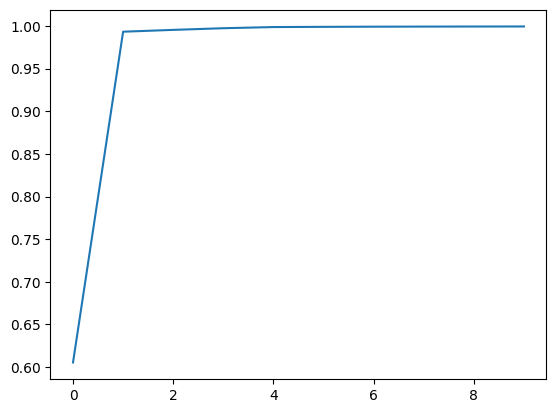

In [23]:
plt.plot(np.cumsum(pca_variance_captured))